# Image Classification with Transfer Learning
Built by: Gary Sampson, DatumSam AI

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import os
import pathlib
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
tf.random.set_seed(42)
np.random.seed(123)

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [2]:
# load image data from URL
import pathlib
dataset_url = "http://download.tensorflow.org/example_images/flower_photos.tgz" 
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True, cache_subdir='C:/Users/garys/Documents/Github')
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 6s 0us/step


In [4]:
# Split the flowers_photos folder into train, validate, test folders
#!pip install split-folders 

In [3]:
#import splitfolders

#splitfolders.ratio('C:/Users/garys/Documents/Github/flower_photos',
                   #output='C:/Users/garys/Documents/Github/flower_photos', seed=123, ratio=(0.75, 0.15, 0.10))

Copying files: 3670 files [00:15, 241.22 files/s]


In [4]:
# Resize the images to 150x150 pixels

batch_size = 32
image_h = 150
image_w = 150

In [5]:
# Perform data augmentation since the flower dataset is small
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a train ImageDataGenerator object 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True)

In [6]:
# Load and iterate train dataset
train_generator = train_datagen.flow_from_directory(
  'C:/Users/garys/Documents/Github/flower_photos/train/',
  target_size=(image_h, image_w),
  batch_size=batch_size,
  shuffle = True,
  seed=123,
  class_mode='sparse')

Found 2750 images belonging to 5 classes.


In [7]:
train_generator.class_indices

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [8]:
train_labels = train_generator.classes
train_labels

array([0, 0, 0, ..., 4, 4, 4])

In [9]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer

# reference: https://towardsdatascience.com/dealing-with-imbalanced-data-in-tensorflow-class-weights-60f876911f99
def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

In [10]:
class_weights = generate_class_weights(train_labels)
class_weights

{0: 1.160337552742616,
 1: 0.8172362555720654,
 2: 1.1458333333333333,
 3: 1.049618320610687,
 4: 0.9181969949916527}

In [11]:
# Load and iterate validation dataset
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
  'C:/Users/garys/Documents/Github/flower_photos/val/',
  target_size=(image_h, image_w),
  batch_size=batch_size,
  shuffle = True,
  seed=123,
  class_mode='sparse')

Found 547 images belonging to 5 classes.


In [12]:
# Load and iterate test dataset
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
  'C:/Users/garys/Documents/Github/flower_photos/test/',
  target_size=(image_h, image_w),
  batch_size=batch_size,
  seed=123,
  shuffle = False,
  class_mode='sparse')

Found 373 images belonging to 5 classes.


In [13]:
# Use a VGG16 model (pre-trained on ImageNet)
# Remove the top layers (fully connected layers)
bottom_model = tf.keras.applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))
bottom_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [14]:
def unfreeze_top_layers(model,num_of_layers='None'):
    # First make all the layers trainable 
    for layer in model.layers:
        layer.trainable = True 

    # For freezed layers 
    if num_of_layers == 'None':
        for layer in model.layers:
            layer.trainable = False  # freeze all first
    else:
        num_of_layers = num_of_layers + 1
        for layer in model.layers[:-num_of_layers]:
            layer.trainable = False
    return model

In [15]:
# Freeze all bottom model layers
vgg_freeze_all = unfreeze_top_layers(bottom_model, num_of_layers='None')
vgg_freeze_all.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [26]:
import keras_tuner as kt

In [29]:
def model_freeze(hp):
    hp_units = hp.Int('units', min_value=128, max_value=512, step=128)
    hp_dropout = hp.Choice('dropout', values =  [0.2, 0.4, 0.5])
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    freeze_hp_model = tf.keras.Sequential()
    vgg_freeze_all,
    freeze_hp_model.add(tf.keras.layers.Flatten())
    freeze_hp_model.add(tf.keras.layers.Dense(units=hp_units, activation= 'relu', kernel_initializer= "HeNormal" ))
    freeze_hp_model.add(tf.keras.layers.Dropout(hp_dropout))
    freeze_hp_model.add(tf.keras.layers.Dense(5, activation='softmax'))
    freeze_hp_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return freeze_hp_model

In [30]:
# tune freeze model hyperparameters using random search
tf.keras.backend.clear_session()

random_search_model_freeze = kt.RandomSearch(
    model_freeze, objective="val_accuracy", max_trials=20, overwrite=True,
    directory="image classification", project_name="model_freeze_search",seed=42)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=10, restore_best_weights=True)
random_search_model_freeze.search(train_generator, validation_data=val_generator, epochs=300,
                              callbacks=[early_stopping_cb], class_weight=class_weights)

Trial 20 Complete [00h 04m 22s]
val_accuracy: 0.3400365710258484

Best val_accuracy So Far: 0.5246800780296326
Total elapsed time: 02h 22m 45s
INFO:tensorflow:Oracle triggered exit


In [31]:
top3_freeze_params = random_search_model_freeze.get_best_hyperparameters(num_trials=3)
top3_freeze_params[0].values 

{'units': 256, 'dropout': 0.2, 'learning_rate': 1e-05}

In [16]:
# unfreeze all base model layers
vgg_unfreeze_all = unfreeze_top_layers(bottom_model, num_of_layers=19)
vgg_unfreeze_all.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [33]:
def model_unfreeze(hp):
    hp_units = hp.Int('units', min_value=128, max_value=512, step=128)
    hp_dropout = hp.Choice('dropout', values =  [0.2, 0.4, 0.5])
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    unfreeze_hp_model = tf.keras.Sequential()
    vgg_unfreeze_all,
    unfreeze_hp_model.add(tf.keras.layers.Flatten())
    unfreeze_hp_model.add(tf.keras.layers.Dense(units=hp_units, activation= 'relu', kernel_initializer= "HeNormal" ))
    unfreeze_hp_model.add(tf.keras.layers.Dropout(hp_dropout))
    unfreeze_hp_model.add(tf.keras.layers.Dense(5, activation='softmax'))
    unfreeze_hp_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return unfreeze_hp_model

In [34]:
# tune hyperparameters unfreeze model using random search
tf.keras.backend.clear_session()

random_search_model_unfreeze = kt.RandomSearch(
    model_unfreeze, objective="val_accuracy", max_trials=20, overwrite=True,
    directory="image classification", project_name="model_unfreeze_search",seed=42)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=10, restore_best_weights=True)
random_search_model_unfreeze.search(train_generator, validation_data=val_generator, epochs=300,
                              callbacks=[early_stopping_cb], class_weight=class_weights)

Trial 20 Complete [00h 03m 00s]
val_accuracy: 0.38574039936065674

Best val_accuracy So Far: 0.5393053293228149
Total elapsed time: 02h 48m 11s
INFO:tensorflow:Oracle triggered exit


In [35]:
top3_unfreeze_params = random_search_model_unfreeze.get_best_hyperparameters(num_trials=3)
top3_unfreeze_params[0].values 

{'units': 384, 'dropout': 0.2, 'learning_rate': 1e-05}

In [17]:
# Build model with bottom vgg16 layers unfrozen using parameters from hyperparameter search
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([vgg_unfreeze_all,
                                tf.keras.layers.Flatten(), 
                                tf.keras.layers.Dropout(0.2),     
                                tf.keras.layers.Dense(384, activation= 'relu', kernel_initializer= "HeNormal" ),
                                tf.keras.layers.Dense(5, activation='softmax')])

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-5)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
history = model.fit(train_generator, validation_data=val_generator, epochs=300, callbacks=[early_stopping_cb], class_weight=class_weights)

Epoch 1/300
86/86 [==============================] - 33s 220ms/step - loss: 1.2454 - accuracy: 0.4796 - val_loss: 0.8103 - val_accuracy: 0.7002
Epoch 2/300
86/86 [==============================] - 18s 212ms/step - loss: 0.6888 - accuracy: 0.7527 - val_loss: 0.5787 - val_accuracy: 0.8007
Epoch 3/300
86/86 [==============================] - 19s 216ms/step - loss: 0.5121 - accuracy: 0.8065 - val_loss: 0.5264 - val_accuracy: 0.8190
Epoch 4/300
86/86 [==============================] - 19s 217ms/step - loss: 0.4319 - accuracy: 0.8371 - val_loss: 0.4939 - val_accuracy: 0.8300
Epoch 5/300
86/86 [==============================] - 19s 218ms/step - loss: 0.3960 - accuracy: 0.8531 - val_loss: 0.4271 - val_accuracy: 0.8501
Epoch 6/300
86/86 [==============================] - 19s 219ms/step - loss: 0.3496 - accuracy: 0.8673 - val_loss: 0.4264 - val_accuracy: 0.8464
Epoch 7/300
86/86 [==============================] - 19s 225ms/step - loss: 0.3247 - accuracy: 0.8749 - val_loss: 0.3951 - val_accuracy:

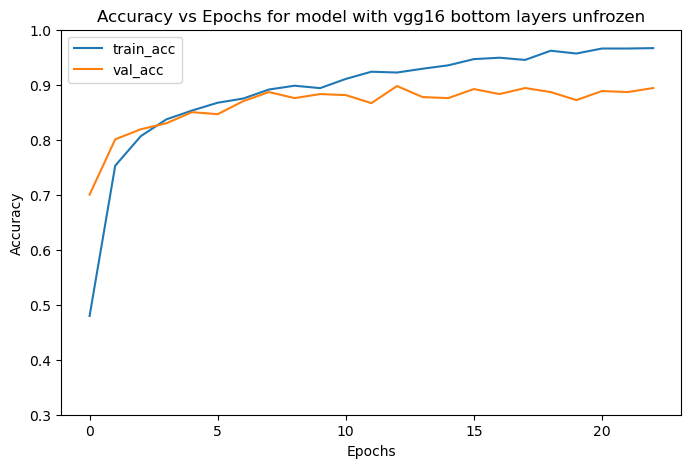

In [19]:
# Plot the learning curves
N = np.arange(0, len(history.history['loss']))
plt.figure(figsize=(8, 5))
plt.gca().set_ylim(0.3, 1.0)
plt.plot(N, history.history["accuracy"], label="train_acc")
plt.plot(N, history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs for model with vgg16 bottom layers unfrozen")
plt.legend()

In [20]:
# Evaluate with the model with all VGG16 layers unfrozen for best hyperparameters 
test_loss,test_accuracy = model.evaluate_generator(test_generator)
print('test_loss: ', test_loss)
print('Test accuracy:', test_accuracy)

test_loss:  0.3730855882167816
Test accuracy: 0.8713136911392212


In [21]:
model_version = "001"
model_name = "image_classification_model"
model_path = os.path.join(model_name, model_version)
tf.saved_model.save(model, model_path)

INFO:tensorflow:Assets written to: image_classification_model\001\assets


INFO:tensorflow:Assets written to: image_classification_model\001\assets


In [22]:
# Confusion matrix

test_predictions = model.predict_generator(test_generator)
test_predicts = np.argmax(test_predictions, axis=-1)
test_trues = test_generator.classes
print("Confusion Matrix for clf6 Model")
cm = confusion_matrix(test_trues, test_predicts)
cm

Confusion Matrix for clf6 Model


array([[55,  1,  2,  1,  6],
       [ 3, 79,  1,  7,  1],
       [ 0,  0, 63,  0,  2],
       [ 0,  0,  1, 68,  2],
       [ 3,  1, 15,  2, 60]], dtype=int64)

In [23]:
# Precision score 
class_names = np.array(list(val_generator.class_indices.keys()))
print(class_names)
precision = precision_score(test_trues, test_predicts,labels=[0, 1, 2, 3, 4],average=None)
print(precision)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']
[0.90163934 0.97530864 0.76829268 0.87179487 0.84507042]


In [24]:
#Recall score 
print(class_names)
recall = recall_score(test_trues, test_predicts,labels=[0, 1, 2, 3, 4],average=None)
print(recall)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']
[0.84615385 0.86813187 0.96923077 0.95774648 0.74074074]


In [25]:
# Accuracy Score for clf6 model
accuracy = accuracy_score(test_trues, test_predicts)
print('Accuracy Score:',accuracy)

Accuracy Score: 0.871313672922252


In [26]:
np.average(recall)

0.8764007406260929

In [27]:
np.average(precision)

0.8724211926989032

**Summary**

The best accuracy of 87.1% was achieved with all bottom layers of the VGG16 unfrozen using hyperparameters of learning rate = 1e-5 and dropout = 0.2 with one fully connected top layer having 384 neurons. Average precision = 87.2% and average recall = 87.6%







